<a href="https://colab.research.google.com/github/kamilllonly1/PianoFlow/blob/master/Klass_ruk_chisel_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [52]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [53]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

In [54]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [55]:
X_train = X_train.float()
X_test = X_test.float()

In [56]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [57]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

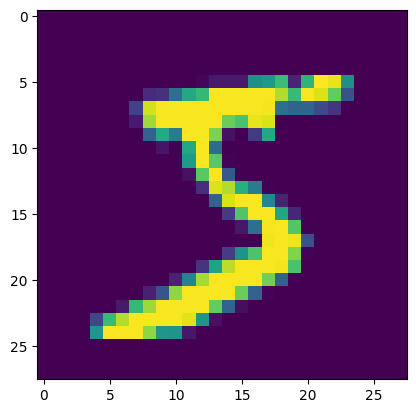

tensor(5)


In [58]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [59]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [60]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

mnist_net = MNISTNet(100)

In [61]:
torch.cuda.is_available()

True

In [62]:
!nvidia-smi

Sat Dec 13 21:26:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P0             29W /   70W |     362MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [63]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -

In [64]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [65]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(25):
    order = np.random.permutation(len(X_train))

    epoch_train_loss = 0
    batch_count = 0

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = mnist_net.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

        epoch_train_loss += loss_value.item()
        batch_count += 1

    train_loss_history.append(epoch_train_loss / batch_count)

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9063, device='cuda:0')
tensor(0.9142, device='cuda:0')
tensor(0.9185, device='cuda:0')
tensor(0.9239, device='cuda:0')
tensor(0.9243, device='cuda:0')
tensor(0.9252, device='cuda:0')
tensor(0.9227, device='cuda:0')
tensor(0.9276, device='cuda:0')
tensor(0.9310, device='cuda:0')
tensor(0.9358, device='cuda:0')
tensor(0.9361, device='cuda:0')
tensor(0.9329, device='cuda:0')
tensor(0.9346, device='cuda:0')
tensor(0.9302, device='cuda:0')
tensor(0.9346, device='cuda:0')
tensor(0.9364, device='cuda:0')
tensor(0.9438, device='cuda:0')
tensor(0.9424, device='cuda:0')
tensor(0.9413, device='cuda:0')
tensor(0.9405, device='cuda:0')
tensor(0.9392, device='cuda:0')
tensor(0.9338, device='cuda:0')
tensor(0.9384, device='cuda:0')
tensor(0.9408, device='cuda:0')
tensor(0.9404, device='cuda:0')


In [66]:
test_accuracy_history = [float(x) for x in test_accuracy_history]
test_loss_history = [float(x) for x in test_loss_history]

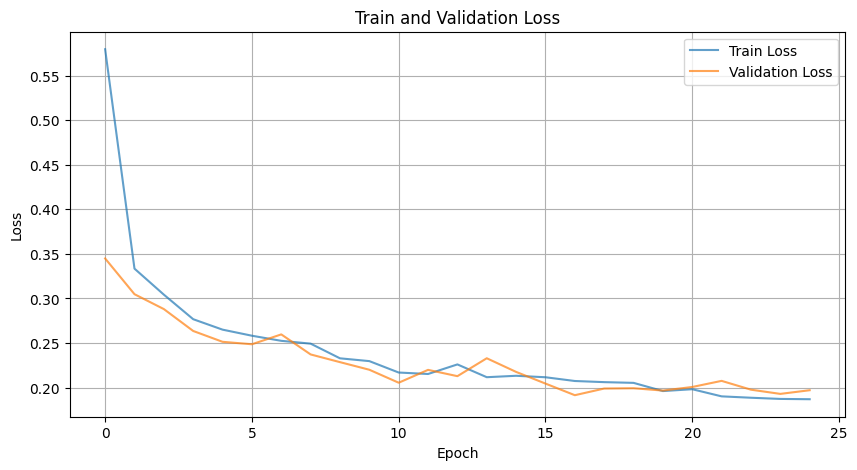

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss', alpha=0.7)
plt.plot(test_loss_history, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

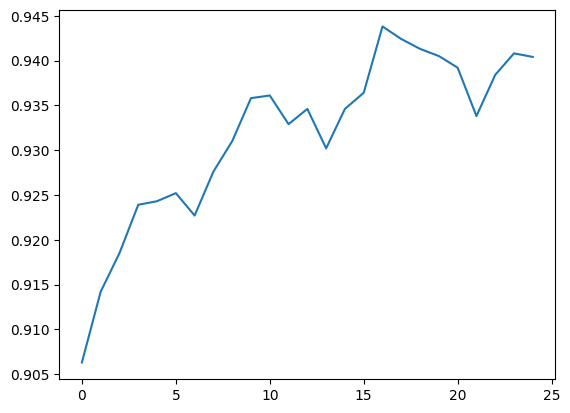

In [68]:
plt.plot(test_accuracy_history)

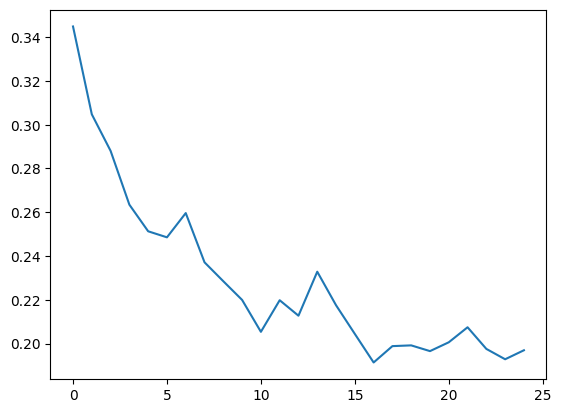

In [69]:
plt.plot(test_loss_history);